In [5]:

import os
import glob
import sys
import tifffile
import numpy
import random

from collections import defaultdict
from tqdm.auto import tqdm
from matplotlib import pyplot, colormaps
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(0, "..")
from utils import savefig

CONDITIONS = ["toRings", "toFibers"]
FEATURES = ["Rings", "Fibers"]
PATH = "./factin-rings-fibers-experiment"

COLORS = {
    "toRings" : "tab:green",
    "toFibers" : "magenta"
}
rings_to_fibers = LinearSegmentedColormap.from_list('ringstofibers', ['tab:green', 'magenta'], N=256, gamma=1.0)
colormaps.register(rings_to_fibers, force=True)
colormaps.register(rings_to_fibers.reversed(), force=True)

def get_files_per_condition():
    """
    Gets all the files in the factin-rings-fibers-experiment directory
    and returns a dictionary with the files per condition.

    Returns:
    --------
    out : dict
        A dictionary with the files per condition.
    """
    out = {}
    for condition in CONDITIONS:
        files = glob.glob(os.path.join(PATH, "unet-segmentation", f"*{condition}*.tif"))
        out[condition] = files
    return out
    
def extract_feature(file):
    """
    Extracts the feature from the file.

    Parameters:
    -----------
    file : str
        The file to extract the feature from.

    Returns:
    --------
    """
    image = tifffile.imread(file)
    feature = image.mean(axis=(1, 2))
    return feature

def gen_trajectory(files):
    trajectories = defaultdict(list)
    for file in files:
        name = os.path.basename(file).split('.')[0].split("_")[-3]
        trajectories[name].append(file)
        
    for name, files in tqdm(trajectories.items(), desc="Loading trajectories"):
        files = list(sorted(files, key=lambda x: int(os.path.basename(x).split('.')[0].split("_")[-1])))

        timesteps, features = [], []
        for file in files:
            timesteps.append(int(os.path.basename(file).split('.')[0].split("_")[-1]))
            features.append(extract_feature(file))
        yield name, numpy.array(timesteps), numpy.array(features)

/tmp/ipykernel_3623138/1530151072.py:26: UserWarning: Overwriting the cmap 'ringstofibers' that was already in the registry.
  colormaps.register(rings_to_fibers, force=True)
/tmp/ipykernel_3623138/1530151072.py:27: UserWarning: Overwriting the cmap 'ringstofibers_r' that was already in the registry.
  colormaps.register(rings_to_fibers.reversed(), force=True)


In [2]:
files_per_condition = get_files_per_condition()

trajectory_id_per_condition, timesteps_per_condition, trajectories_per_condition = defaultdict(list), defaultdict(list), defaultdict(list)

for condition, files in files_per_condition.items():
    for name, timesteps, features in gen_trajectory(files):
        trajectory_id_per_condition[condition].extend([name] * len(timesteps))
        timesteps_per_condition[condition].extend(timesteps)
        trajectories_per_condition[condition].append(features)


Loading trajectories:   0%|          | 0/20 [00:00<?, ?it/s]

Loading trajectories:   0%|          | 0/21 [00:00<?, ?it/s]

toRings


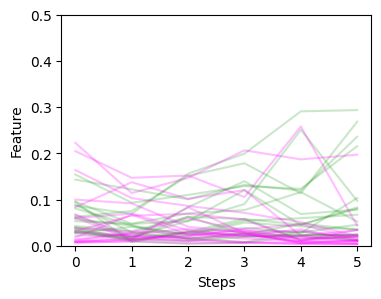

toFibers


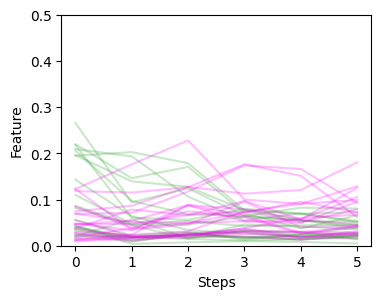

In [6]:
for condition in CONDITIONS:
    print(condition)
    trajectories = numpy.array(trajectories_per_condition[condition])

    # Plots the features as a function of time
    fig, ax = pyplot.subplots(figsize=(4, 3))
    cmap = pyplot.get_cmap("ringstofibers", trajectories.shape[-1])
    for t in range(trajectories.shape[-1]):
        for trajectory in trajectories[:, :, t]:
            ax.plot(trajectory, color=cmap(t), alpha=0.25)
    ax.set(
        ylim=(0, 0.5),
        ylabel="Feature",
        xlabel="Steps"
    )
    ax.set_xticks(
        numpy.arange(0, trajectories.shape[1], 1),
    )

    savefig(fig, f"./factin-rings-fibers-experiment/panels/raw-trajectories-{condition}", save_white=True)

    pyplot.show()    

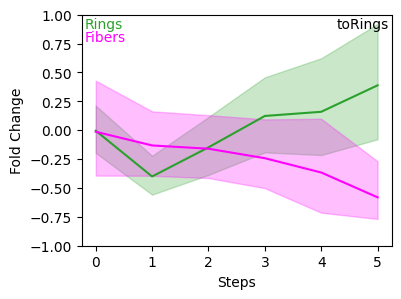

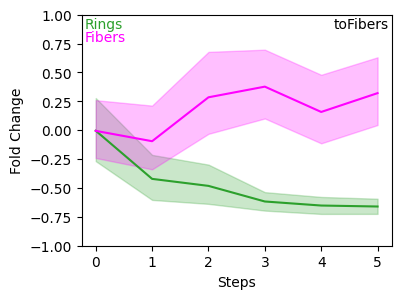

In [7]:
class FoldChangeScaler:
    def __init__(self, trajectory_id, index=0):
        self.index = index

        self.baseline = None

    def fit_transform(self, X, trajectory_id=None):
        if trajectory_id is None:
            baselines = X[:, [self.index]]
            self.baseline = numpy.mean(baselines, axis=0, keepdims=True)

            return (X - baselines) / baselines

        X = X.copy()
        baselines = []
        for trajectory in set(trajectory_id):
            mask = trajectory_id == trajectory
            baseline = X[mask][[self.index], :]
            baselines.append(baseline)
        baseline = numpy.mean(baselines, axis=0)
        # X = numpy.log2(X + 1) - numpy.log2(baseline + 1)
        X = (X - baseline) / baseline
        # X[mask] = (X[mask] - baseline) / baseline
        return X

# Generate bootstrap trajectories
def bootstrap(samples, n=1000):
    out = []
    for _ in range(n):
        items = numpy.random.choice(samples, len(samples))
        bootstrap_sample = []
        for item in items:
            mask = trajectory_id == item
            bootstrap_sample.append(trajectories[mask])
        mean = numpy.mean(bootstrap_sample, axis=0)

        out.append(mean)
    out = numpy.array(out)
    return out

def get_confidence_interval(bootstrapped_trajectory, indices, axis=0):
    mean, cid, ciu = numpy.percentile(numpy.take(bootstrapped_trajectory, indices, axis=axis), [50, 5.0, 95], axis=0) 
    return mean, cid, ciu   

def from_categorical(names):
    unique_names = list(sorted(set(names)))
    return numpy.array([unique_names.index(name) for name in names])

def convert_timesteps(timesteps, invert=False):
    unique_timesteps = list(sorted(set(timesteps)))
    return numpy.array([
        max(unique_timesteps) - unique_timesteps.index(t) if invert else unique_timesteps.index(t) for t in timesteps])

def get_mask_real_images(timesteps):
    return numpy.array([t == 0 for t in timesteps])

random.seed(42)
numpy.random.seed(42)

for condition in CONDITIONS:

    n = 10000
    trajectories = numpy.array(trajectories_per_condition[condition])
    trajectory_id = numpy.array(trajectory_id_per_condition[condition])

    trajectories_ = trajectories.copy()

    # Fold change scaling to plot the data
    scaler = FoldChangeScaler(trajectory_id, index=0)
    trajectories = scaler.fit_transform(trajectories.reshape(-1, trajectories.shape[-1]), trajectory_id=trajectory_id)

    bootstrapped_trajectory = bootstrap(list(set(trajectory_id)), n)

    fig, ax = pyplot.subplots(figsize=(4, 3))
    cmap = pyplot.get_cmap("ringstofibers", bootstrapped_trajectory.shape[-1])
    for t in range(bootstrapped_trajectory.shape[-1]):
        mean, cid, ciu = get_confidence_interval(bootstrapped_trajectory, t, axis=2)
        ax.plot(mean, color=cmap(t))
        ax.fill_between(
            numpy.arange(0, bootstrapped_trajectory.shape[1], 1),
            cid, ciu, color=cmap(t), alpha=0.25
        )
        # for trajectory in bootstrapped_trajectory[:, :, t]:
        #     ax.plot(trajectory, color=cmap(t), alpha=0.1)
        ax.annotate(
            FEATURES[t],
            xy=(0.01, 1 - 0.35 * (t + 1)/bootstrapped_trajectory.shape[1]), color=cmap(t),
            xycoords='axes fraction',
            horizontalalignment='left'
        )
    ax.annotate(
        condition,
        xy=(0.99, 0.99),
        xycoords='axes fraction',
        horizontalalignment='right',
        verticalalignment='top'
    )
    ax.set(
        ylim=(-1.0, 1.0), ylabel="Fold Change", xlabel="Steps"
    )
    # ax.set_xticks(
    #     numpy.arange(0, len(sorted_idx), 1), labels=[FEATURES[i] for i in sorted_idx],
    #     rotation=45
    # )
    # savefig(fig, "./activity-experiment/figures/manual-features/{}_trajectory-per-steps".format(condition), save_white=True)
    savefig(fig, f"./factin-rings-fibers-experiment/panels/bootstrapped-trajectories-{condition}", save_white=True)
    pyplot.show()

    bootstrapped_trajectory_id = numpy.array([[f'bootstrap_{i}' for _ in range(bootstrapped_trajectory.shape[-1])] for i in range(len(bootstrapped_trajectory))]).ravel()
    bootstrapped_timesteps = numpy.array([[i for i in range(bootstrapped_trajectory.shape[-1])] for _ in range(len(bootstrapped_trajectory))]).ravel()
    bootstrapped_trajectory = bootstrapped_trajectory.reshape(-1, bootstrapped_trajectory.shape[-1])

    # mask = bootstrapped_timesteps != 0
    # bootstrapped_timesteps = bootstrapped_timesteps[mask]
    # bootstrapped_trajectory = bootstrapped_trajectory[mask]
    # bootstrapped_trajectory_id = bootstrapped_trajectory_id[mask]

    # print(bootstrapped_trajectory.shape)